In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import warnings
from statsmodels.stats.multitest import multipletests, local_fdr
from scipy.stats import zscore, uniform
import matplotlib.pyplot as plt
import DynaTMT_SB.DynaTMT as mePROD
#import mssuite.mssuite as ms

warnings.filterwarnings("ignore")

In [4]:
wd = r"C:\Users\Predator\Desktop\Testing\Example data" # you can define your folder here etc: C://Users/Jasmin/Desktop/JS55/fractionation/
dataName = "20200724_MAA_SB_126_CCCP+ISRIB_Import_Peptides.txt"

peptides = pd.read_csv(f'{wd}/{dataName}', sep='\t', header=0) # TEXT or CSV file: you provide your .txt PSM or peptide file here.

# psms = pd.read_excel(f'{wd}/{dataName}', sep='\t', header=0) #  EXCEL file: you provide your .xlsx  PSM or peptide file here.

print(peptides.dtypes)

Peptide Groups Peptide Group ID                        int64
Checked                                                 bool
Confidence                                            object
Annotated Sequence                                    object
Modifications                                         object
Contaminant                                             bool
Qvality PEP                                          float64
Qvality q-value                                      float64
# Protein Groups                                       int64
# Proteins                                             int64
# PSMs                                                 int64
Master Protein Accessions                             object
Positions in Master Proteins                          object
Modifications in Master Proteins                      object
# Missed Cleavages                                     int64
Theo. MH+ [Da]                                       float64
Abundances (Normalized):

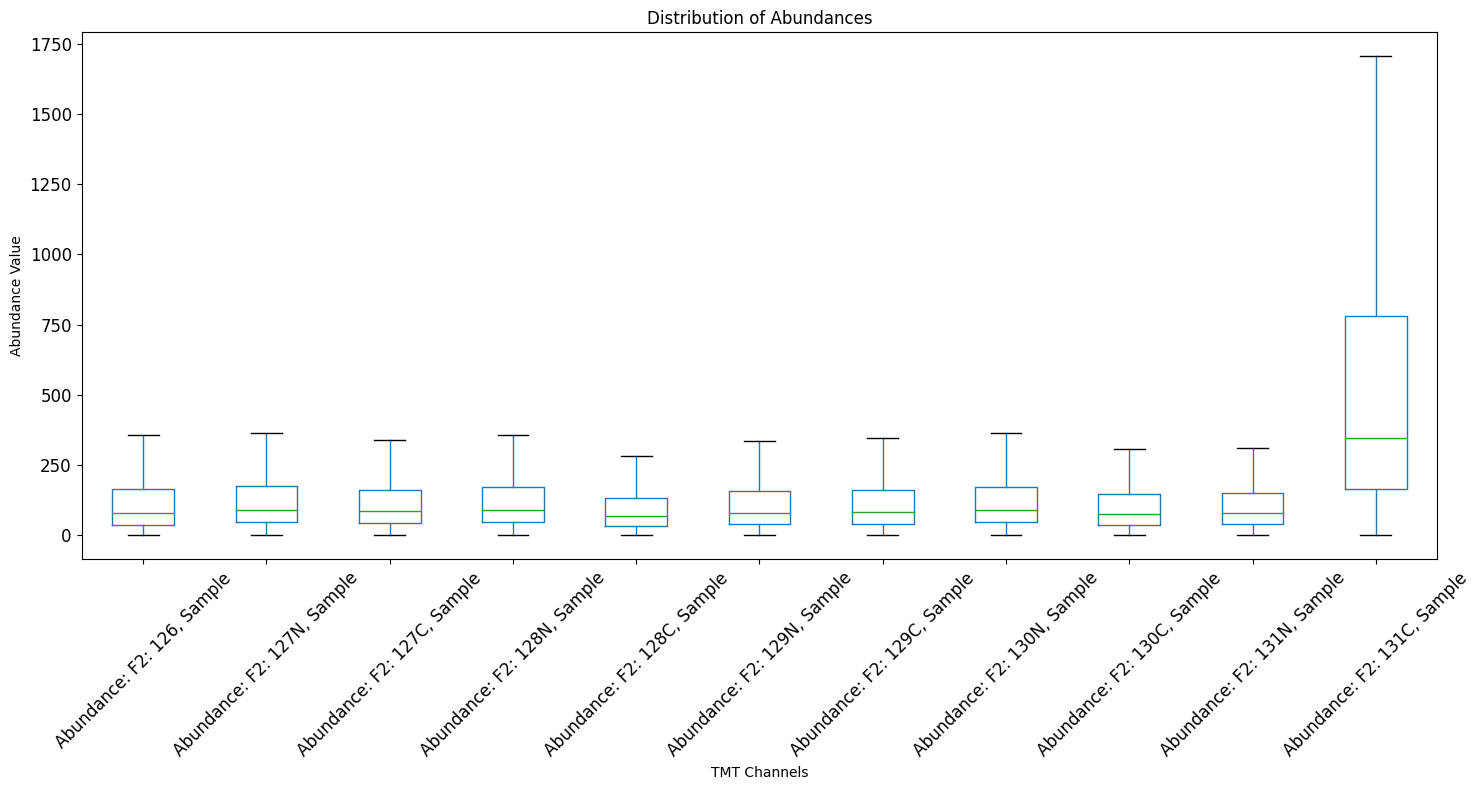

In [5]:
abundance_columns = [col for col in peptides.columns if 'Abundance:' in col]
abundance_df = peptides[abundance_columns]

# Displaying the first few rows of the extracted abundance columns
abundance_df.head()

# Plotting the abundance columns using a boxplot
plt.figure(figsize=(15, 8))
abundance_df.boxplot(grid=False, vert=True, fontsize=12, rot=45, showfliers=False)
plt.title("Distribution of Abundances")
plt.ylabel("Abundance Value")
plt.xlabel("TMT Channels")
plt.tight_layout()
plt.show()

In [15]:
process = mePROD.PD_input() 

def filter_peptides(input_file1, PSMs = False):
    if PSMs:
        input_file1 = input_file1[~input_file1['Master Protein Accessions'].str.contains(';',na=False)]
        input_file1 = input_file1[input_file1['Contaminant']==False]
        try:
            input_file1 = input_file1.dropna(subset=['Average Reporter SN'])
            input_file1 = input_file1[input_file1['Average Reporter SN'] != 0]
        except:
            input_file1 = input_file1.dropna(subset=['Average Reporter S/N'])
            input_file1 = input_file1[input_file1['Average Reporter S/N'] != 0]
    else:
        input_file1 = input_file1[input_file1['Quan Info'] != 'NotUnique']
        input_file1 = input_file1[input_file1['Contaminant'] == False]
        input_file1 = input_file1[input_file1['Quan Info'] != 'NoQuanValues']

    return input_file1

def extract_heavy (input):
    print("Extraction of labelled peptides")
    modi = list([col for col in input.columns if 'Modification' in col])[0]
    if modi == []:
        modi = list([col for col in input.columns if 'Modifications' in col])[0]
    '''Change Modification String here'''
    Heavy_peptides=input[input[modi].str.contains('TMTK8|Label|TMTproK8|TMTK4|TMTK6',na=False)]

    print("Extraction Done","Extracted Peptides:", len(Heavy_peptides))
    return Heavy_peptides

In [16]:
filter_data = filter_peptides(peptides, PSMs = False)
filter_data

,Peptide Groups Peptide Group ID,Checked,Confidence,Annotated Sequence,Modifications,Contaminant,Qvality PEP,Qvality q-value,# Protein Groups,# Proteins,...,"Found in Sample: [S17] F2: 129N, Sample","Found in Sample: [S18] F2: 129C, Sample","Found in Sample: [S19] F2: 130N, Sample","Found in Sample: [S20] F2: 130C, Sample","Found in Sample: [S21] F2: 131N, Sample","Found in Sample: [S22] F2: 131C, Sample",Confidence (by Search Engine): Sequest HT,Percolator q-Value (by Search Engine): Sequest HT,Percolator PEP (by Search Engine): Sequest HT,XCorr (by Search Engine): Sequest HT
0,1,False,High,[R].AAAAAAAAAAAAAAAGAGAGAK.[Q],1xTMT6plex [K22]; 1xTMT6plex [N-Term],False,3.417920e-12,0.000010,1,1,...,High,High,High,High,High,High,High,0.000008,5.704000e-13,6.25
1,131498,False,High,[K].ISNLTIVQAEIK.[D],1xTMT6plex [K12]; 1xTMT6plex [N-Term],False,2.136500e-05,0.000010,1,1,...,High,High,High,High,High,High,High,0.000008,9.164000e-06,3.83
2,224756,False,High,[K].VSDLENEAK.[K],1xTMT6plex [K9]; 1xTMT6plex [N-Term],False,1.314160e-05,0.000010,1,1,...,High,High,High,High,High,High,High,0.000008,5.482000e-06,3.08
3,131500,False,High,[K].ISNIVIKDDVASEVYK.[A],1xTMT6plex [N-Term]; 2xTMTK8 [K7; K16],False,4.042210e-05,0.000010,1,1,...,High,High,High,High,High,High,High,0.000008,1.800000e-05,2.96
4,131503,False,High,[R].LSNMAMGK.[T],1xTMT6plex [K8]; 1xTMT6plex [N-Term],False,3.205850e-04,0.000010,1,1,...,High,High,High,High,High,High,High,0.000008,1.624000e-04,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92100,144498,False,High,[R].MGSVER.[M],1xLabel:13C(6)15N(4) [R6]; 1xTMT6plex [N-Term],False,1.435540e-01,0.009999,1,1,...,High,High,High,High,High,High,High,0.006406,9.873000e-02,1.96
92101,150596,False,High,[R].MTADGR.[L],1xOxidation [M1]; 1xLabel:13C(6)15N(4) [R6]; 1...,False,1.441080e-01,0.009999,1,1,...,High,High,High,Not Found,Not Found,High,High,0.006410,9.888000e-02,1.14
92102,118027,False,High,[K].ILGILALIDEGETDWK.[L],1xTMT6plex [K16]; 1xTMT6plex [N-Term],False,1.435540e-01,0.009999,1,1,...,High,High,High,High,High,High,High,0.006401,9.869000e-02,1.66
92103,94607,False,High,[K].HQYLHR.[H],1xLabel:13C(6)15N(4) [R6]; 1xTMT6plex [N-Term],False,1.441080e-01,0.009999,1,1,...,High,High,High,High,High,High,High,0.006410,9.894000e-02,1.50


,Peptide Groups Peptide Group ID,Checked,Confidence,Annotated Sequence,Modifications,Contaminant,Qvality PEP,Qvality q-value,# Protein Groups,# Proteins,...,"Found in Sample: [S17] F2: 129N, Sample","Found in Sample: [S18] F2: 129C, Sample","Found in Sample: [S19] F2: 130N, Sample","Found in Sample: [S20] F2: 130C, Sample","Found in Sample: [S21] F2: 131N, Sample","Found in Sample: [S22] F2: 131C, Sample",Confidence (by Search Engine): Sequest HT,Percolator q-Value (by Search Engine): Sequest HT,Percolator PEP (by Search Engine): Sequest HT,XCorr (by Search Engine): Sequest HT


In [9]:
psms

,Peptide Groups Peptide Group ID,Checked,Confidence,Annotated Sequence,Modifications,Contaminant,Qvality PEP,Qvality q-value,# Protein Groups,# Proteins,...,"Found in Sample: [S17] F2: 129N, Sample","Found in Sample: [S18] F2: 129C, Sample","Found in Sample: [S19] F2: 130N, Sample","Found in Sample: [S20] F2: 130C, Sample","Found in Sample: [S21] F2: 131N, Sample","Found in Sample: [S22] F2: 131C, Sample",Confidence (by Search Engine): Sequest HT,Percolator q-Value (by Search Engine): Sequest HT,Percolator PEP (by Search Engine): Sequest HT,XCorr (by Search Engine): Sequest HT
0,1,False,High,[R].AAAAAAAAAAAAAAAGAGAGAK.[Q],1xTMT6plex [K22]; 1xTMT6plex [N-Term],False,3.417920e-12,0.000010,1,1,...,High,High,High,High,High,High,High,0.000008,5.704000e-13,6.25
1,131498,False,High,[K].ISNLTIVQAEIK.[D],1xTMT6plex [K12]; 1xTMT6plex [N-Term],False,2.136500e-05,0.000010,1,1,...,High,High,High,High,High,High,High,0.000008,9.164000e-06,3.83
2,224756,False,High,[K].VSDLENEAK.[K],1xTMT6plex [K9]; 1xTMT6plex [N-Term],False,1.314160e-05,0.000010,1,1,...,High,High,High,High,High,High,High,0.000008,5.482000e-06,3.08
3,131500,False,High,[K].ISNIVIKDDVASEVYK.[A],1xTMT6plex [N-Term]; 2xTMTK8 [K7; K16],False,4.042210e-05,0.000010,1,1,...,High,High,High,High,High,High,High,0.000008,1.800000e-05,2.96
4,131503,False,High,[R].LSNMAMGK.[T],1xTMT6plex [K8]; 1xTMT6plex [N-Term],False,3.205850e-04,0.000010,1,1,...,High,High,High,High,High,High,High,0.000008,1.624000e-04,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92101,150596,False,High,[R].MTADGR.[L],1xOxidation [M1]; 1xLabel:13C(6)15N(4) [R6]; 1...,False,1.441080e-01,0.009999,1,1,...,High,High,High,Not Found,Not Found,High,High,0.006410,9.888000e-02,1.14
92102,118027,False,High,[K].ILGILALIDEGETDWK.[L],1xTMT6plex [K16]; 1xTMT6plex [N-Term],False,1.435540e-01,0.009999,1,1,...,High,High,High,High,High,High,High,0.006401,9.869000e-02,1.66
92103,94607,False,High,[K].HQYLHR.[H],1xLabel:13C(6)15N(4) [R6]; 1xTMT6plex [N-Term],False,1.441080e-01,0.009999,1,1,...,High,High,High,High,High,High,High,0.006410,9.894000e-02,1.50
92104,40187,False,High,[K].DTVLQR.[T],1xLabel:13C(6)15N(4) [R6]; 1xTMT6plex [N-Term],False,1.441080e-01,0.009999,1,1,...,High,High,High,High,High,High,High,0.006420,9.907000e-02,1.84
